In [1]:
import FinanceDataReader as fdr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
# CSV 파일 불러오기
df = pd.read_csv("C:/Users/jinwo/Downloads/AAME.csv")

# 날짜 컬럼 datetime 형으로 변환
df['Date'] = pd.to_datetime(df['Date'])

# 1. 2016년 이후 데이터 필터링
df = df[df['Date'] >= '2016-01-01']
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,4.99,4.99,4.77,4.84,4.728858,8300
2016-01-05,4.80,4.89,4.57,4.57,4.465058,4900
2016-01-06,4.70,4.70,4.65,4.70,4.592073,1900
2016-01-07,4.66,4.66,4.41,4.58,4.474829,1700
2016-01-08,4.62,4.65,4.46,4.46,4.357584,6400
...,...,...,...,...,...,...
2020-03-26,2.29,2.29,2.08,2.28,2.280000,1600
2020-03-27,2.25,2.25,2.21,2.25,2.250000,500
2020-03-30,2.25,2.25,2.13,2.13,2.130000,400


In [23]:
# 2. 특징값 정규화
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [25]:
# 3. 시퀀스 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 3])  # 'Close' 예측
    return np.array(X), np.array(y)

In [27]:
# 4. 시퀀스 생성
sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

In [29]:
# 5. 훈련/테스트 분리
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [53]:
# 6. LSTM 모델 구성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(16, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\jinwo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
# 7. 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=32)

# 8. 예측
predicted = model.predict(X_test)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0013
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0013
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0013
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - lo

In [62]:
# 9. 역정규화 (Close만 복원)
close_index = features.index('Close')
min_val = scaler.min_[close_index]
scale_val = scaler.scale_[close_index]
predicted_prices = predicted * scale_val + min_val
real_prices = y_test * scale_val + min_val

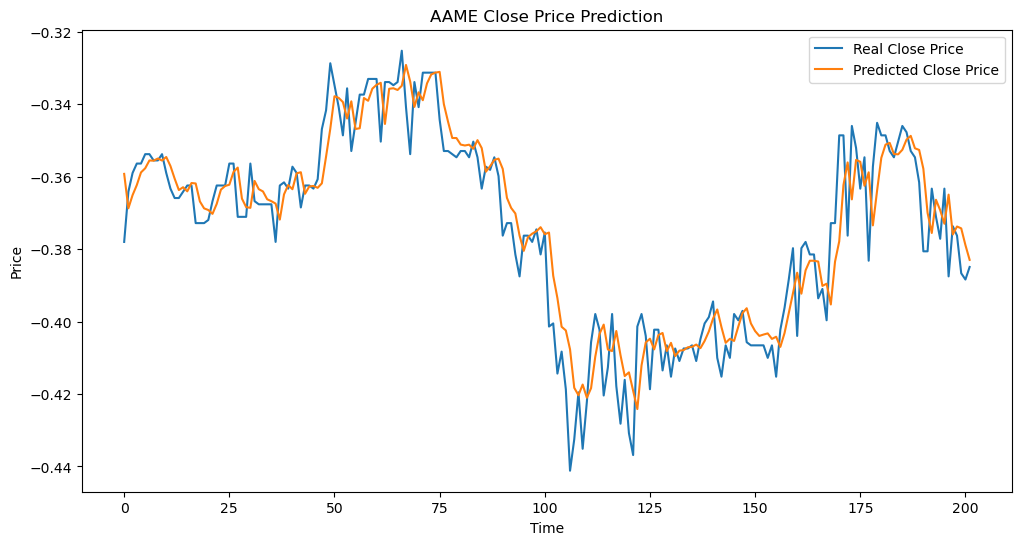

In [63]:
# 10. 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(real_prices, label='Real Close Price')
plt.plot(predicted_prices, label='Predicted Close Price')
plt.title('AAME Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()